In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 0
setup_one_gpu(GPU)

Picking GPU 0


In [2]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph
from general_tools.in_out.basics import create_dir, files_in_subdirs

from geo_tool import Point_Cloud

from tf_lab.in_out.basics import Data_Splitter, read_saved_epochs
from tf_lab.point_clouds.ae_templates import mlp_architecture_ala_iclr_18, default_train_params

from tf_lab.point_clouds.autoencoder import Configuration as Conf
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder

from tf_lab.point_clouds.in_out import load_point_clouds_from_filenames, PointCloudDataSet
from tf_lab.data_sets.shape_net import pc_loader as snc_loader
from tf_lab.data_sets.shape_net import snc_category_to_synth_id

from tf_lab.point_clouds.latent_gan import LatentGAN
from tf_lab.point_clouds.generators_discriminators import latent_code_discriminator_two_layers, \
latent_code_generator_two_layers, latent_code_discriminator, latent_code_generator

from tf_lab.iclr.helper import load_multiple_version_of_pcs, find_best_validation_epoch_from_train_stats
from tf_lab.point_clouds.convenience import get_latent_codes
from tf_lab.neural_net import MODEL_SAVER_ID

from tf_lab.point_clouds.raw_gan_gp import RawGAN_GP
from tf_lab.point_clouds.generators_discriminators import latent_code_generator

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [13]:
n_pc_points = 2048
random_seed = 42
do_training = True
plot_train_curve = True 
save_synthetic_samples = True
save_model = False
max_epochs = 2000
saver_step = np.hstack([np.array([1, 5, 10]), np.arange(100, max_epochs+1, 100)])
class_name = raw_input('Give me the class type.\n').lower()
syn_id = snc_category_to_synth_id()[class_name]
ae_loss = 'emd'
do_wgan = True
b_neck = int(raw_input('Give me bneck_size.\n'))
ae_experiment_tag = 'mlp_with_split_1pc_usampled_bnorm_on_encoder_only'
special_tag = 'lgan_arch'

Give me the class type.
chair
Give me bneck_size.
128


In [14]:
if do_wgan:
    gan_tag = 'l_w_gan'
else:
    gan_tag = 'l_gan'

experiment_tag = '_'.join([gan_tag, class_name, ae_experiment_tag, ae_loss, 'bneck', str(b_neck)])

if special_tag is not None:
    experiment_tag += '_' + special_tag

print experiment_tag

l_w_gan_chair_mlp_with_split_1pc_usampled_bnorm_on_encoder_only_emd_bneck_128_lgan_arch


In [15]:
top_data_dir = '/orions4-zfs/projects/optas/DATA/'
in_data = load_multiple_version_of_pcs('uniform_one', syn_id, n_classes=1)
train_data = in_data['train']

679 pclouds were loaded. They belong in 1 shape-classes.
5761 pclouds were loaded. They belong in 1 shape-classes.
338 pclouds were loaded. They belong in 1 shape-classes.


In [16]:
synthetic_data_out_dir = osp.join(top_data_dir, 'OUT/iclr/synthetic_samples/', gan_tag, experiment_tag)
create_dir(synthetic_data_out_dir)
train_dir = osp.join(top_data_dir, 'OUT/iclr/nn_models', experiment_tag)
create_dir(train_dir)

'/orions4-zfs/projects/optas/DATA/OUT/iclr/nn_models/l_w_gan_chair_mlp_with_split_1pc_usampled_bnorm_on_encoder_only_emd_bneck_128_lgan_arch'

In [17]:
# Load Auto-Encoder
ae_id = '_'.join(['ae', class_name, ae_experiment_tag, str(n_pc_points), 'pts', str(b_neck), 'bneck', ae_loss])
ae_train_dir = osp.join(top_data_dir, 'OUT/iclr/nn_models/', ae_id)
ae_conf = Conf.load(osp.join(ae_train_dir, 'configuration'))
saved_epochs = read_saved_epochs(ae_conf.train_dir)
_, best_epoch = find_best_validation_epoch_from_train_stats(osp.join(ae_train_dir, 'train_stats.txt'))
if best_epoch % ae_conf.saver_step != 0: # Model was not saved at that epoch.
    best_epoch += best_epoch % ae_conf.saver_step
ae_conf.encoder_args['verbose'] = False
ae_conf.decoder_args['verbose'] = False
reset_tf_graph()
ae = PointNetAutoEncoder(ae_conf.experiment_name, ae_conf)    
ae.restore_model(ae_conf.train_dir, best_epoch, verbose=True)

Model restored in epoch 400.


In [18]:
# Convert raw-data to latent codes.
latent_codes = get_latent_codes(ae, train_data.point_clouds)
train_data = PointCloudDataSet(latent_codes)

In [19]:
init_lr = 0.0001
batch_size = 50
noise_params = {'mu':0, 'sigma': 0.2}
noise_dim = b_neck
n_syn_samples = train_data.num_examples
n_out = [b_neck]
accum_syn_data = []
train_stats = []

In [21]:
reset_tf_graph()

if do_wgan:
    lam = 10
    beta = 0.5
    reset_tf_graph()
    gan = RawGAN_GP(experiment_tag, init_lr, lam, n_out, noise_dim, \
                    latent_code_discriminator_two_layers, latent_code_generator_two_layers,\
                    beta=beta                    
                   )
                    # latent_code_discriminator, , latent_code_generator,
#                     gen_kwargs={'layer_sizes': [64, 128], 'b_norm': False}, 
#                     disc_kwargs={'layer_sizes': [512, 1024], 'b_norm': False})
else:
    beta = 0.5
    gan = LatentGAN(experiment_tag, init_lr, n_out, noise_dim,
                    latent_code_discriminator_two_layers, latent_code_generator_two_layers,
                    beta=beta
                   )

1 (-4.3794531417929612, -0.40711357019355765)


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


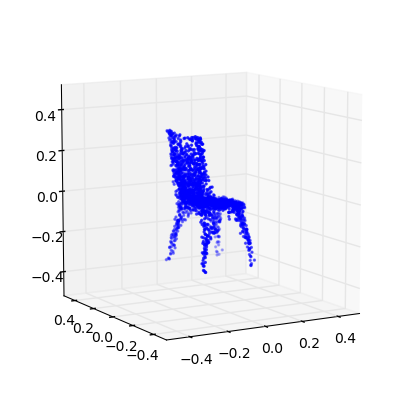

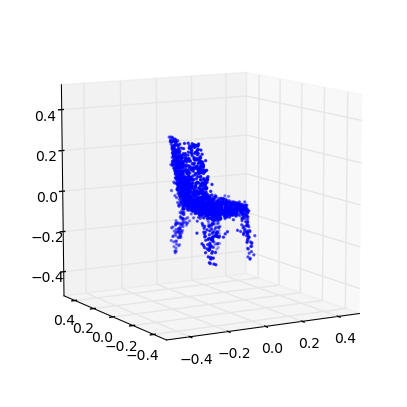

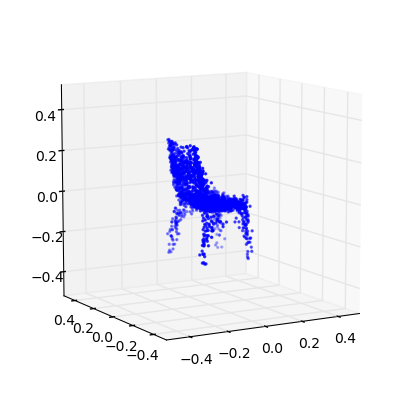

2 (-7.4370596885681151, -0.99740550829016639)
3 (-7.1957256317138674, -1.2777629365091738)
4 (-6.9162077945211662, -1.5936875965284265)
5 (-6.5919393166251803, -1.9433114528656006)


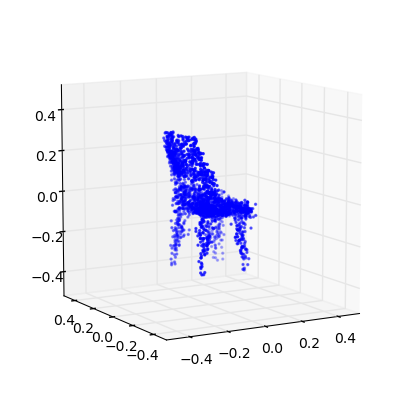

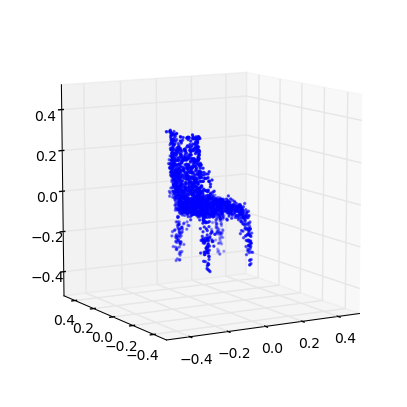

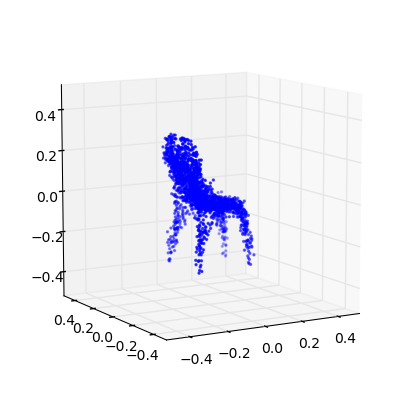

6 (-6.2050422295280123, -2.3107963955920674)
7 (-5.786081741167151, -2.6988359534222148)
8 (-5.3321118147476856, -3.1076413341190503)
9 (-4.8764987945556637, -3.4560526661250903)
10 (-4.4238399049510129, -3.7171015324799912)


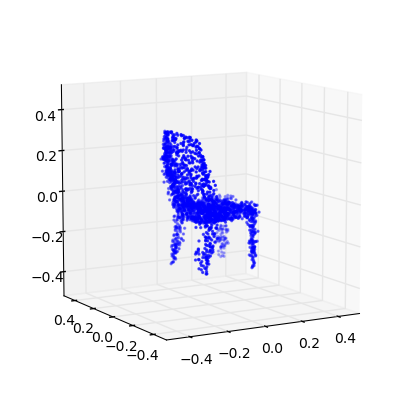

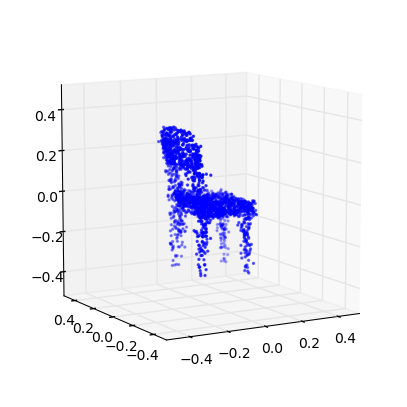

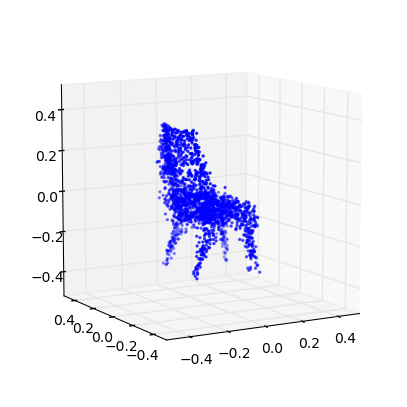

11 (-4.0016947601152504, -3.9508729395659072)
12 (-3.6184042080588963, -4.0627783485080888)
13 (-3.2478222909181014, -4.0774232719255528)
14 (-2.9165874190952468, -4.0586770928424336)
15 (-2.6303295902583912, -3.9075848434282388)
16 (-2.3951582089714383, -3.6635560367418374)
17 (-2.1861348960710609, -3.3103977908258853)
18 (-2.0313189672387164, -2.8923007198002026)
19 (-1.9164005631985872, -2.5515848035397739)
20 (-1.828493328716444, -2.1802838470624839)
21 (-1.7560476043949957, -1.7383682986964351)
22 (-1.7085220150325608, -1.3646169693573662)
23 (-1.6728238043577774, -1.1144072750340337)
24 (-1.6451089537662009, -0.91879990826482361)
25 (-1.6212047110433163, -0.7420470999634784)
26 (-1.5954627410225246, -0.56687314484430396)
27 (-1.5695606656696486, -0.49423833904059039)
28 (-1.5540882038033528, -0.41854735366676166)
29 (-1.525121373715608, -0.33521390155605646)
30 (-1.5051242320433906, -0.3797616291305293)
31 (-1.4857338324837062, -0.24476476540060146)
32 (-1.4605421315068785, -0.28

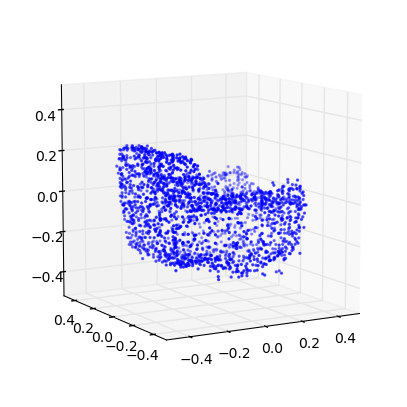

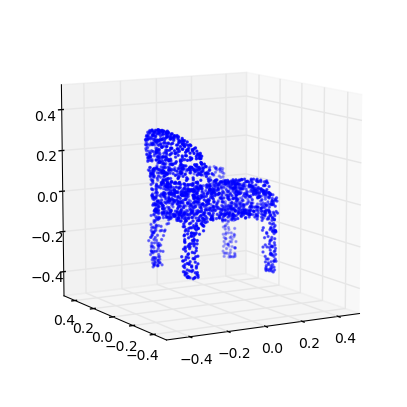

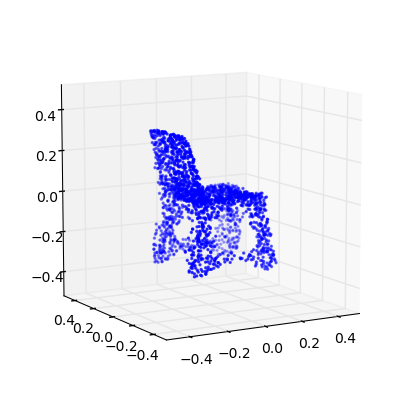

101 (-0.56796713782393415, -0.15235363878309727)
102 (-0.5692529157451961, -0.11551936306869207)
103 (-0.56895836332569949, -0.22463109376637833)
104 (-0.569076910485392, -0.12734485749641192)
105 (-0.56560083135314609, -0.25041934329530469)
106 (-0.57047505611958715, -0.17970045202452203)
107 (-0.56326548172079993, -0.1506076638141404)
108 (-0.56818375561548318, -0.16262427506887395)
109 (-0.56435061304465584, -0.24711203380771304)
110 (-0.55730001304460608, -0.20886918222126755)
111 (-0.56074796785479009, 0.021016470359071442)
112 (-0.55578449601712432, -0.11193170884381169)
113 (-0.55401634859002158, -0.24051038143427475)
114 (-0.55617165720981099, -0.11818523611873388)
115 (-0.54731466562851616, -0.20571695527304773)
116 (-0.55283394766890481, -0.11375670207907325)
117 (-0.5450474306293156, -0.10856167110614479)
118 (-0.55144864087519441, -0.15812805878079456)
119 (-0.55042636860971861, -0.078846274915596717)
120 (-0.55217098671457043, -0.10241190157830715)
121 (-0.5446443215660427

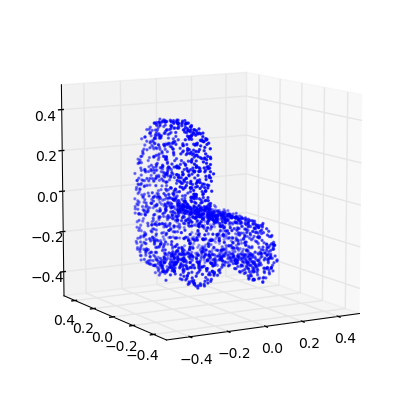

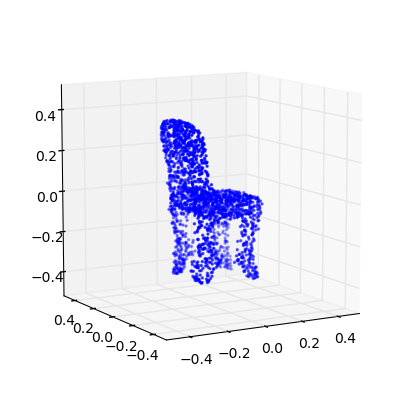

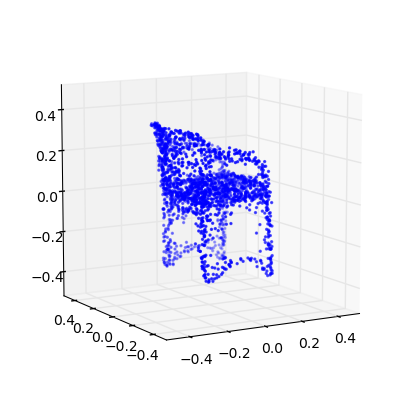

201 (-0.55613171432329256, -0.0055796544108053913)
202 (-0.56391850347104278, 0.048852217424175011)
203 (-0.54906947405441953, 0.012652482634977154)
204 (-0.55144108378368872, 0.035456226247808205)
205 (-0.55431295918381729, -0.01893705619580072)
206 (-0.54716224489004717, 0.051652056731931538)
207 (-0.54805070161819458, 0.015655810296859429)
208 (-0.54526042782742046, 0.015726065951520981)
209 (-0.54632271502328955, -0.038799961583445904)
210 (-0.55026194841965381, 0.044768898140477097)
211 (-0.54942893800528159, 0.03172369091771543)
212 (-0.55201725052750628, -0.028150390266724255)
213 (-0.54452197914538181, -0.067175514874574932)
214 (-0.54510434347650283, 0.0038914426695555449)
215 (-0.53814697058304495, -0.017900330905357132)
216 (-0.54409512333247978, 0.019220851564212986)
217 (-0.54699247168458032, 0.030585342005867024)
218 (-0.54940582358318824, -0.020710910913412987)
219 (-0.54803592873656226, -0.0051454922346317253)
220 (-0.54846146469530854, -0.002200323541689178)
221 (-0.54

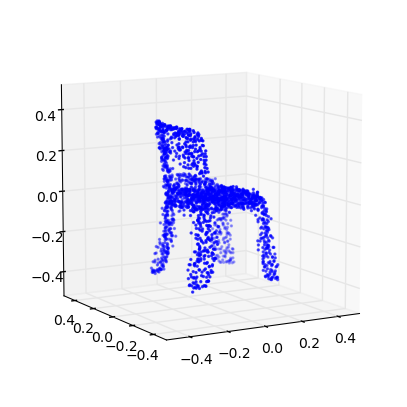

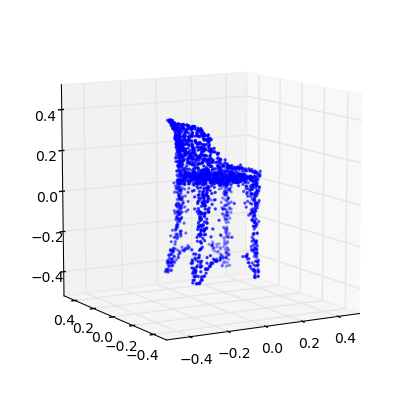

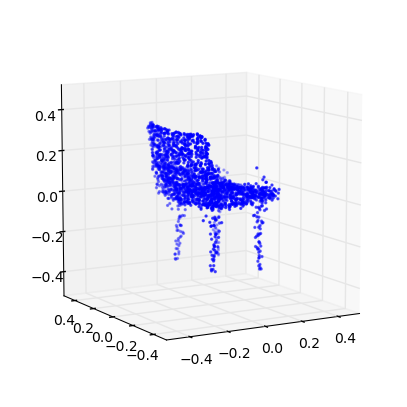

301 (-0.52551412841548095, 0.064188579340343888)
302 (-0.5224128557288128, 0.022304079252416672)
303 (-0.51962639015653855, 0.021759123541414738)
304 (-0.52304234115973758, 0.042279726461223931)
305 (-0.52243048159972483, 0.066852971304046077)
306 (-0.53014172885728916, 0.049559771923510278)
307 (-0.52051121773927111, 0.040014988621291908)
308 (-0.52694019804830139, 0.013190459298050922)
309 (-0.52619476007378618, 0.077192931152556252)
310 (-0.52373888570329419, 0.085693058537562261)
311 (-0.52128158237623134, 0.045973540810139282)
312 (-0.52459358210149021, 0.033898618639163346)
313 (-0.52786761781443725, 0.055361110636073609)
314 (-0.52091706524724546, 0.065843323691059719)
315 (-0.52397209924200305, 0.055340451046662485)
316 (-0.51876907504123193, 0.044063772803739361)
317 (-0.52038864311964617, 0.06603794747396656)
318 (-0.52444377748862558, 0.040173363244241991)
319 (-0.52157984350038611, 0.061999857547166554)
320 (-0.52389179701390476, 0.052022940216019102)
321 (-0.51971216227697

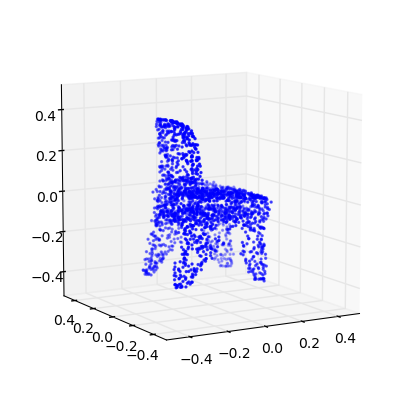

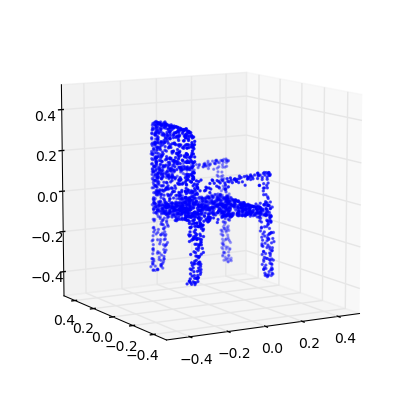

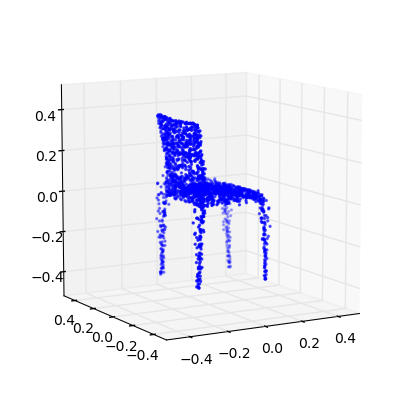

401 (-0.51958783916805107, 0.0029315962658628173)
402 (-0.5056886413823003, -0.013158200511141964)
403 (-0.51713404474051106, -0.0075801311911124249)
404 (-0.51570797951325131, -0.00088902469724416733)
405 (-0.51115287101787066, 0.021599897001262591)
406 (-0.51204448057257612, -0.0025781170343575272)
407 (-0.50801056493883545, 0.02138550454021796)
408 (-0.51427318998005078, -0.0037919622238563456)
409 (-0.51710273312485733, -0.0091061727751208382)
410 (-0.51286448888156722, -0.013410773391470961)
411 (-0.51552644993947905, -0.0029101834187041159)
412 (-0.51215157094209085, -0.026946330645486065)
413 (-0.51494994759559631, -0.021427543773113386)
414 (-0.51007273663645203, 0.019425103683834492)
415 (-0.51474026804384976, 0.018266020970338064)
416 (-0.5161537066749905, -0.0074874654655223303)
417 (-0.50720059068306633, -0.0013501869271630826)
418 (-0.51241491773854131, -0.016430065137050722)
419 (-0.50984590934670493, 0.0023133420061482034)
420 (-0.51002834309702338, -0.004367150933198307

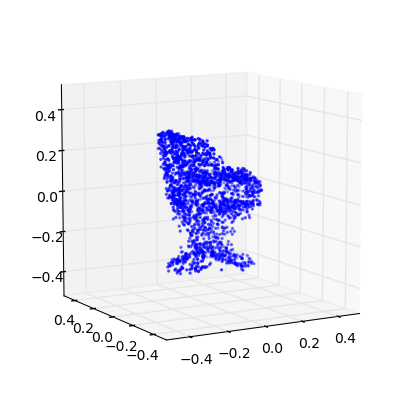

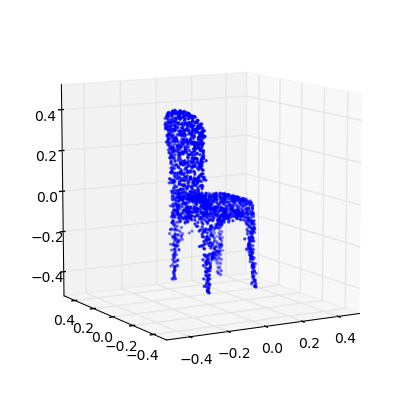

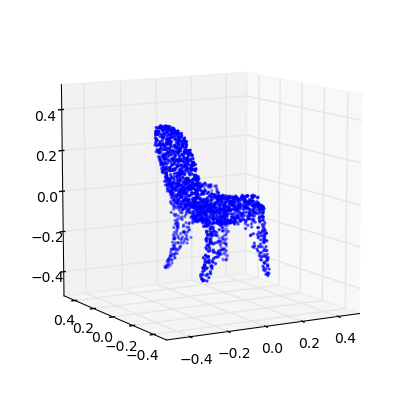

501 (-0.50929736935574077, -0.054422072215896587)
502 (-0.50970363020896914, -0.046148695173146931)
503 (-0.51972352084906204, -0.056070234788500747)
504 (-0.51465821084768881, -0.045428731256043131)
505 (-0.51394119081289869, -0.056300738502455795)
506 (-0.51091840448586834, -0.061663381309936878)
507 (-0.51167756319046021, -0.028726927855092545)
508 (-0.51088015748106919, -0.062675062405026474)
509 (-0.51495011759840925, -0.048807073870430824)
510 (-0.50590063799982488, -0.042866505358530128)
511 (-0.51398736419885049, -0.0825002616190392)
512 (-0.50886429237282793, -0.073377891565146652)
513 (-0.50440389021583221, -0.069179983566636627)
514 (-0.51279173078744311, -0.05230368363023128)
515 (-0.50638641740964807, -0.067831359601215183)
516 (-0.51176194185795987, -0.057130385311725346)
517 (-0.51081486862638725, -0.075028642526139389)
518 (-0.51239903957947441, -0.057214725155221378)
519 (-0.50975146708281149, -0.082283613656688001)
520 (-0.50757389716480095, -0.085510750179705414)
521

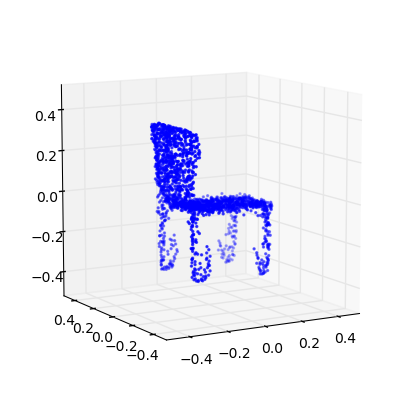

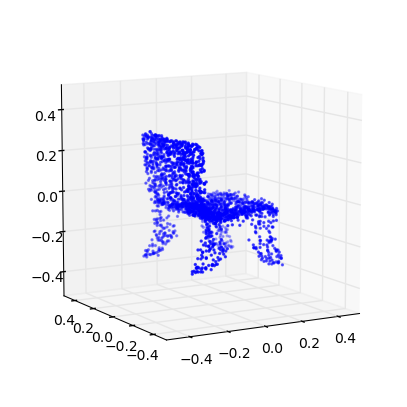

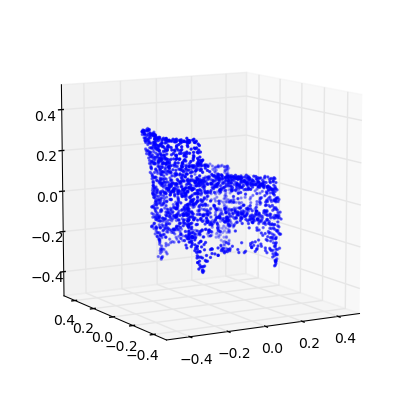

601 (-0.51101197496704431, -0.085612430763633354)
602 (-0.50132306658703352, -0.079860723536947495)
603 (-0.50044550921605979, -0.053301136171364269)
604 (-0.50068067752796674, -0.0568209835935546)
605 (-0.50080932767494868, -0.076334505018008786)
606 (-0.50932599332021633, -0.071471487455393959)
607 (-0.5061477689639382, -0.075334156256007118)
608 (-0.50816594051278152, -0.082719308040712189)
609 (-0.50271407054818196, -0.079071810145093041)
610 (-0.50793287572653401, -0.035024113021790981)
611 (-0.50918181979137922, -0.080752628652945815)
612 (-0.50734357833862309, -0.06705721477856455)
613 (-0.50601084802461704, -0.07238543572147256)
614 (-0.51099678226139233, -0.044786925569338644)
615 (-0.49998702717863996, -0.059280166402459145)
616 (-0.51052262472069787, -0.066799267154672867)
617 (-0.49891364056131116, -0.069713992431111954)
618 (-0.50920786417048913, -0.0668949392705184)
619 (-0.50188229343165525, -0.077377257463724716)
620 (-0.50329861096713857, -0.071632620514087059)
621 (-0

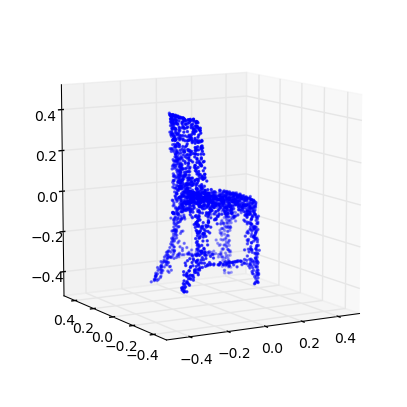

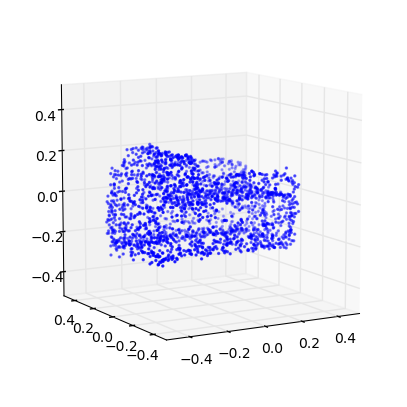

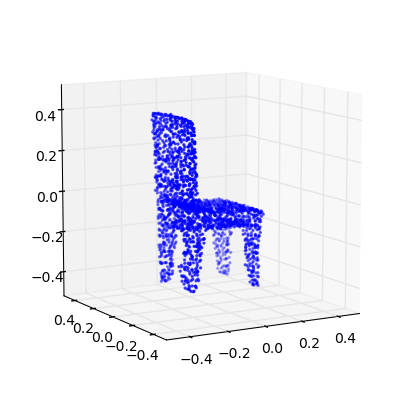

701 (-0.50349220322526023, -0.032230151736217995)
702 (-0.50069977511530339, -0.016093715883629477)
703 (-0.49743147155512935, -0.034225860934542572)
704 (-0.49279169751250224, -0.043493936607695141)
705 (-0.50076630892960916, -0.05053760743011599)
706 (-0.50441002171972527, -0.038462201214354973)
707 (-0.50224170036937876, -0.045689321689955563)
708 (-0.50149773411128828, -0.015007762116906435)
709 (-0.4994602856428727, -0.04751374671721588)
710 (-0.50464534448540732, -0.015960401450486286)
711 (-0.49987171551455623, -0.048555446363499628)
712 (-0.4990488402221514, -0.055237421887400356)
713 (-0.49559336745220683, -0.048066457409573639)
714 (-0.49800351624903472, -0.045887292625949434)
715 (-0.50057583295780683, -0.022967377637067566)
716 (-0.50483782084091855, -0.053309328408668873)
717 (-0.5005307189796282, -0.041133510718203106)
718 (-0.50803826606791957, -0.023912112046357081)
719 (-0.49928091557129567, -0.037284928212023297)
720 (-0.50297955015431284, -0.037262914459342544)
721 (

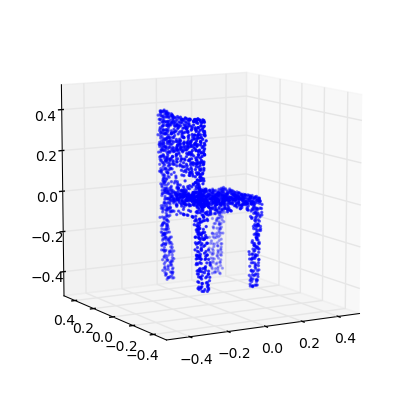

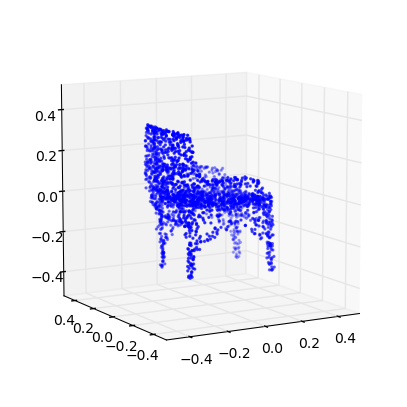

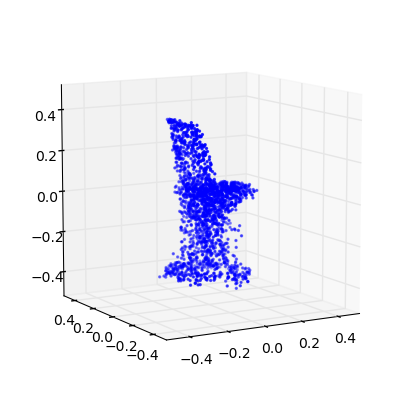

801 (-0.4936772673026375, -0.0011731499158169913)
802 (-0.49647582069687224, 0.0018796768930295239)
803 (-0.50342524544052458, -0.00076697414497966349)
804 (-0.49641774141270184, -0.016960417001467686)
805 (-0.49831233724303869, -0.022559809093566044)
806 (-0.49815918855045155, 0.0032862187565668769)
807 (-0.49856375170790629, 0.0049286400291906748)
808 (-0.50367360218711521, -0.008722954510670641)
809 (-0.49237289480541063, 0.023134926212546619)
810 (-0.49076392832009691, 0.0099364688377017556)
811 (-0.4935258969016697, -0.005377955572760623)
812 (-0.4967824453892915, -0.00092547224915545917)
813 (-0.49761614877244703, -0.0027348263108212013)
814 (-0.494602217104124, -0.0095357121899724007)
815 (-0.49301108173702074, -0.0016186359621908355)
816 (-0.49872318972711976, 0.0029771318355494218)
817 (-0.49333550981853319, -0.011140350414359051)
818 (-0.49706416803857556, 0.020106761068429634)
819 (-0.50061232965925462, -0.0082292411800311965)
820 (-0.48612385210783587, 0.0046870458628172464

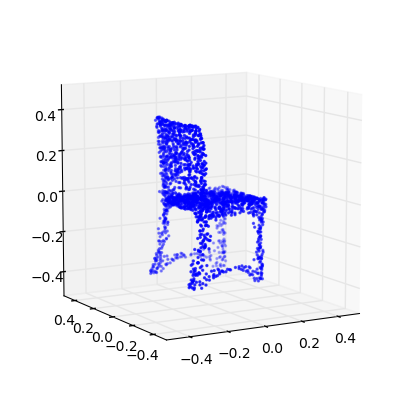

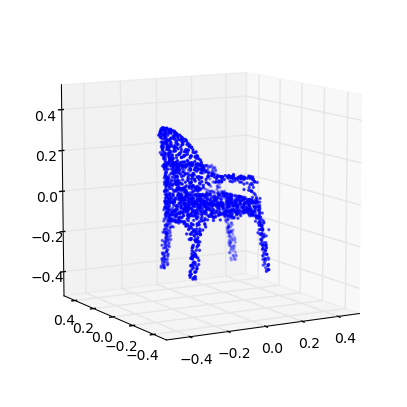

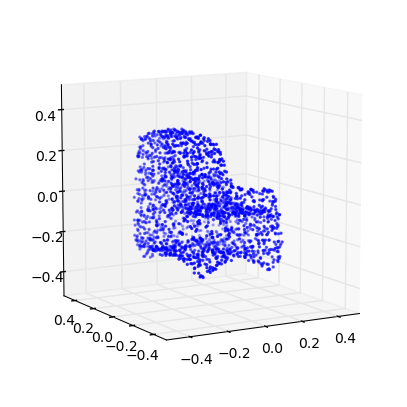

901 (-0.49340841951577558, 0.042910615306185639)
902 (-0.49300895255544913, 0.043716570443433266)
903 (-0.48853729445001354, 0.040234240014915879)
904 (-0.48864263607108077, 0.039630862398316029)
905 (-0.49556500808052395, 0.042734273344926209)
906 (-0.4928997174553249, 0.038677189276432211)
907 (-0.49210487163585165, 0.026585048186066357)
908 (-0.4892360474752343, 0.045003621272094875)
909 (-0.49295691821886145, 0.030085777377952701)
910 (-0.48831500929334887, 0.040495331682588745)
911 (-0.49656248792358065, 0.033462615298998098)
912 (-0.49212946399398472, 0.045737449079751968)
913 (-0.49625163492949115, 0.033367630782658642)
914 (-0.49923663165258325, 0.050126490021205464)
915 (-0.48951650261878965, 0.038169303989928703)
916 (-0.49320618251095649, 0.054139189989022583)
917 (-0.49120453570200051, 0.023886294833020023)
918 (-0.49193316024282702, 0.042913641902091709)
919 (-0.49235532957574596, 0.047480167497111404)
920 (-0.49300320148468019, 0.064565083821830543)
921 (-0.49037127572557

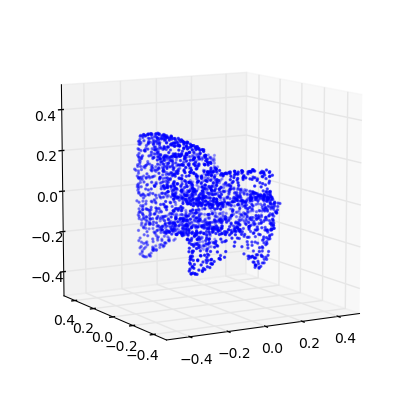

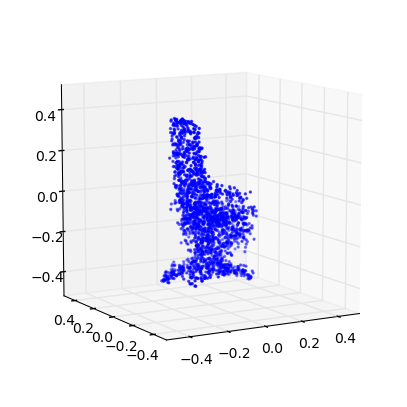

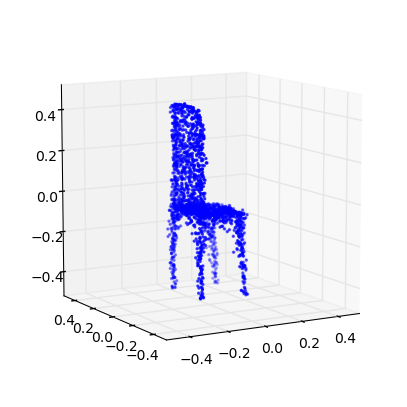

1001 (-0.4868965744972229, 0.087562796254844769)
1002 (-0.4854133004727571, 0.1096282253122848)
1003 (-0.48444463403328603, 0.10646313137334326)
1004 (-0.4897997127926868, 0.072554250450237931)
1005 (-0.48512631887974944, 0.10556082629963108)
1006 (-0.4871567790922911, 0.10028561609594719)
1007 (-0.48593668989513233, 0.11844175276548966)
1008 (-0.48439335408418077, 0.084179640464160752)
1009 (-0.48466810480408046, 0.10021479282042255)
1010 (-0.49254227021466129, 0.10486769125513408)
1011 (-0.48907123570856842, 0.088187776343977967)
1012 (-0.4911569584970889, 0.10199707523798165)
1013 (-0.48828880372254746, 0.091114632299412857)
1014 (-0.48582015322602312, 0.11018159969345383)
1015 (-0.48335378636484561, 0.10086324155006719)
1016 (-0.48642493978790613, 0.10908494029275101)
1017 (-0.48607054067694622, 0.11432612525380176)
1018 (-0.48781281683755956, 0.095332531501417572)
1019 (-0.48103039523829583, 0.093518812614290611)
1020 (-0.48752917776937071, 0.097782200445299561)
1021 (-0.484423459

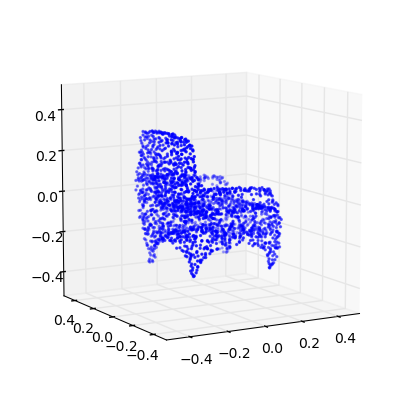

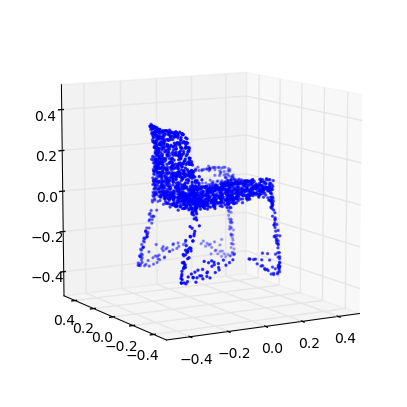

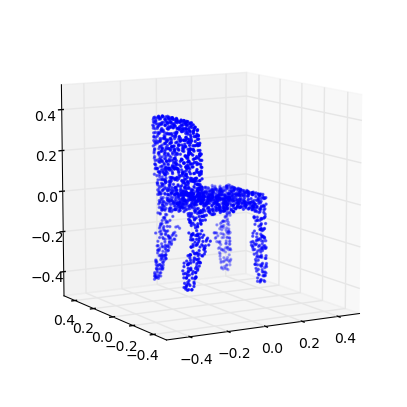

1101 (-0.48212121725082396, 0.12347610294818878)
1102 (-0.47664805987606879, 0.11699367508940074)
1103 (-0.48135708985121356, 0.13231421942296234)
1104 (-0.48383097363554911, 0.11032295988305756)
1105 (-0.48213327345640761, 0.11841164399748264)
1106 (-0.47703906090363213, 0.11486352947743042)
1107 (-0.47903710292733231, 0.11257697285517403)
1108 (-0.47783680921015531, 0.14117846119662988)
1109 (-0.48655682335729183, 0.1348461939588837)
1110 (-0.47803740242253179, 0.11845148630116296)
1111 (-0.47788579671279247, 0.10878614498221356)
1112 (-0.48614006483036537, 0.11897298531687778)
1113 (-0.48243158511493517, 0.12003443163374196)
1114 (-0.48398173166357955, 0.11913026480571083)
1115 (-0.47394555573878083, 0.12851506763178369)
1116 (-0.48159849643707275, 0.097527180352936615)
1117 (-0.48076778702113937, 0.1221003237625827)
1118 (-0.48400583111721535, 0.11575552132790504)
1119 (-0.48086411097775333, 0.12754375325596851)
1120 (-0.48276178759077321, 0.13003098154845444)
1121 (-0.479826959578

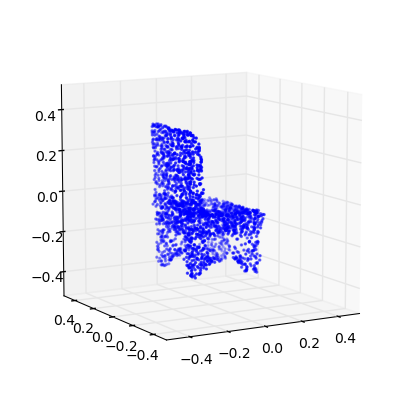

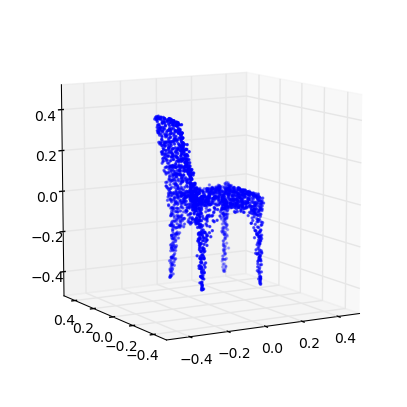

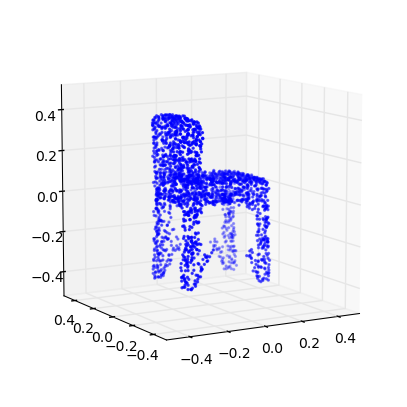

1201 (-0.48052750333495764, 0.13149957294049469)
1202 (-0.48124878484269845, 0.12932866358238718)
1203 (-0.48198739653048306, 0.1423533633351326)
1204 (-0.4715519438619199, 0.13353156104035999)
1205 (-0.4752644717693329, 0.13098764063223547)
1206 (-0.47903425926747528, 0.13007478986907264)
1207 (-0.47237196512844254, 0.13727356072353281)
1208 (-0.47706932295923649, 0.12772525610078289)
1209 (-0.47649199781210527, 0.12594733484413312)
1210 (-0.47217751870984614, 0.12259615876752397)
1211 (-0.47681665653767791, 0.12215215923345607)
1212 (-0.47137175591095631, 0.15611340170321258)
1213 (-0.48217969199885491, 0.13383748090785483)
1214 (-0.47186807756838589, 0.13214607050885324)
1215 (-0.47499771014503811, 0.12071312672418097)
1216 (-0.48098902209945349, 0.13051560035218362)
1217 (-0.47781626271164934, 0.14491992929707403)
1218 (-0.47303240998931551, 0.1357339142781237)
1219 (-0.47701317953026812, 0.1319935010827106)
1220 (-0.4782777664454087, 0.1426744367117467)
1221 (-0.47325551898583124,

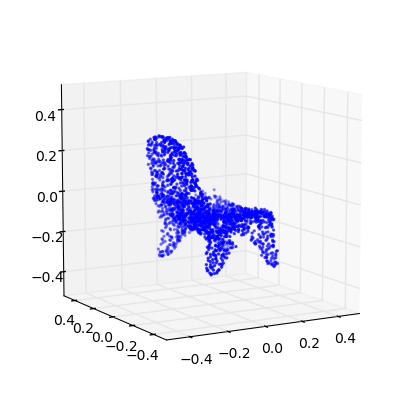

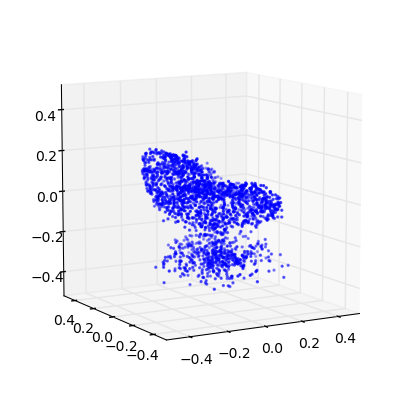

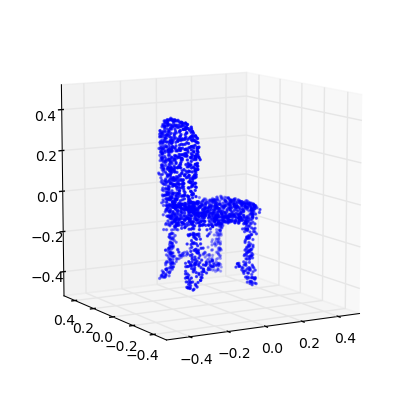

1301 (-0.47653807894043299, 0.15059014150629874)
1302 (-0.47221473870070085, 0.16515932167353836)
1303 (-0.47256806570550669, 0.16485714102568833)
1304 (-0.47432230270427206, 0.17384987259688583)
1305 (-0.47838998411012734, 0.1696216204892034)
1306 (-0.47439780027970024, 0.14669851408056592)
1307 (-0.46961274147033694, 0.1682968275702518)
1308 (-0.4692589601744776, 0.16179505703241928)
1309 (-0.4739620942136516, 0.15516269952058792)
1310 (-0.47339458672896678, 0.16091305082258972)
1311 (-0.47505458671113721, 0.17698397973309393)
1312 (-0.46850984537083168, 0.17163240715213443)
1313 (-0.47743733499361118, 0.16304061270278433)
1314 (-0.47421117062154022, 0.17061847966650259)
1315 (-0.47555298131445178, 0.17071470521066501)
1316 (-0.46941957240519316, 0.17030799486066983)
1317 (-0.47704479927602023, 0.16774326044580209)
1318 (-0.47361076577850009, 0.16000829831413602)
1319 (-0.47665062443069789, 0.18336027698672336)
1320 (-0.46860858072405276, 0.16083414399105569)
1321 (-0.479995828866958

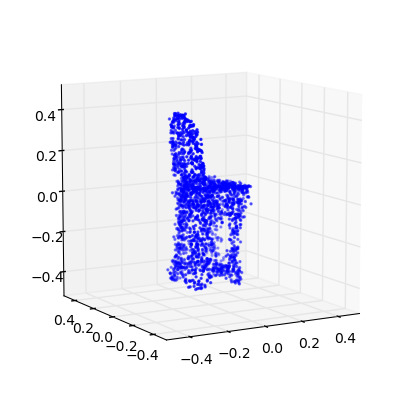

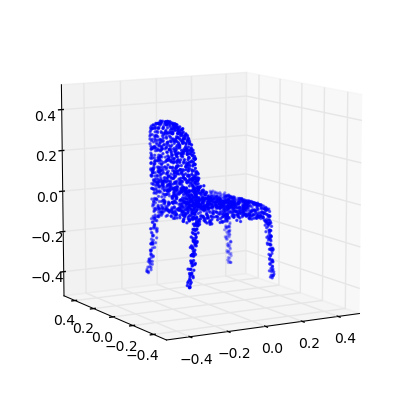

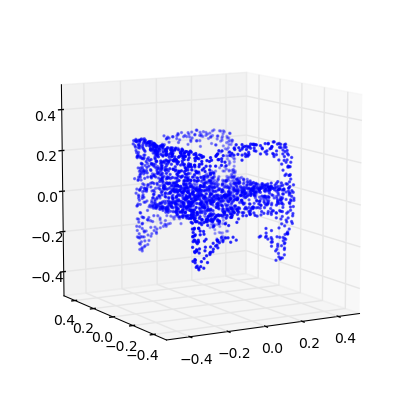

1401 (-0.46590542922849243, 0.18353471419085626)
1402 (-0.46755433030750443, 0.1955353591753089)
1403 (-0.46516175917957142, 0.1881864760880885)
1404 (-0.47422934589178667, 0.21257061478884323)
1405 (-0.47074300646781919, 0.20457529956879822)
1406 (-0.46979172748068104, 0.19779232889413834)
1407 (-0.4713265411231829, 0.1981761274130448)
1408 (-0.46322442111761675, 0.187820287178392)
1409 (-0.46500476391419121, 0.18783911738706671)
1410 (-0.46920755686967269, 0.18803304045096689)
1411 (-0.46616268261619237, 0.19731481276128604)
1412 (-0.46746193714763806, 0.20436535386935525)
1413 (-0.47226545344228332, 0.19213217561659607)
1414 (-0.46739141578259674, 0.19198567258275073)
1415 (-0.4659815612046615, 0.20315907053325488)
1416 (-0.46815172511598341, 0.18711774148370908)
1417 (-0.46497453036515607, 0.19641865595527316)
1418 (-0.46611090198807092, 0.20619192265945932)
1419 (-0.47136553525924685, 0.21887110044126926)
1420 (-0.4626284078411434, 0.18483343461285467)
1421 (-0.4644107530946317, 0

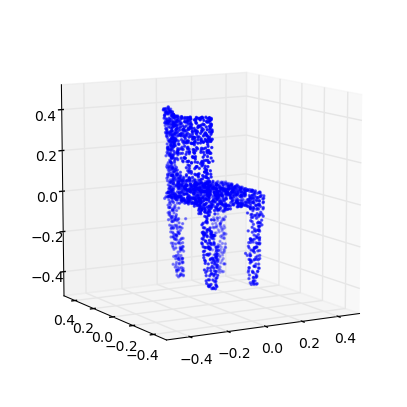

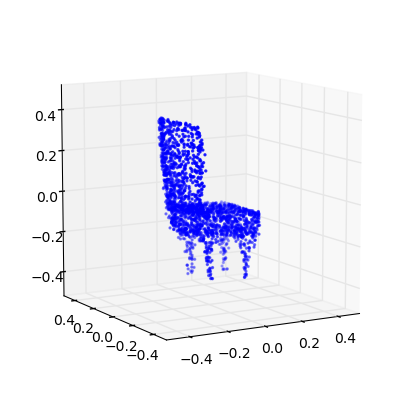

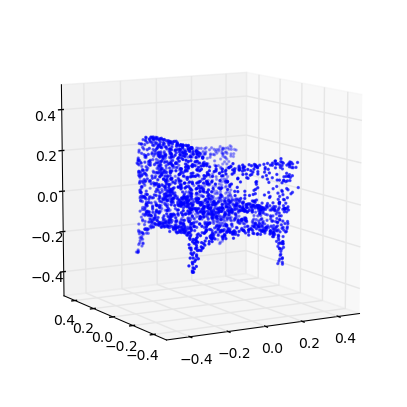

1501 (-0.46588440278302068, 0.20826548985812976)
1502 (-0.46325637309447582, 0.19818665022435394)
1503 (-0.46294562039167986, 0.21031100626872934)
1504 (-0.46317476656125939, 0.20502172086549841)
1505 (-0.46652992186339004, 0.20577103936153909)
1506 (-0.46623102556104246, 0.20570067219112231)
1507 (-0.46477641281874282, 0.19410465268985086)
1508 (-0.46404035169145336, 0.20121053897816202)
1509 (-0.46448632400968798, 0.19719008259151294)
1510 (-0.46789639644000841, 0.20273275219875833)
1511 (-0.46553323320720508, 0.19684493865655817)
1512 (-0.46320552229881284, 0.18755904455547748)
1513 (-0.46345182061195372, 0.17844746844924014)
1514 (-0.46449241379032963, 0.18340072780847549)
1515 (-0.46687938389570816, 0.19652153357215549)
1516 (-0.46218984386195305, 0.17513015412766)
1517 (-0.46908038206722424, 0.18154913996872696)
1518 (-0.46430475141691124, 0.22121490343757297)
1519 (-0.46992394846418628, 0.19492115015568939)
1520 (-0.46003641045611837, 0.18112819058739621)
1521 (-0.45494938933331

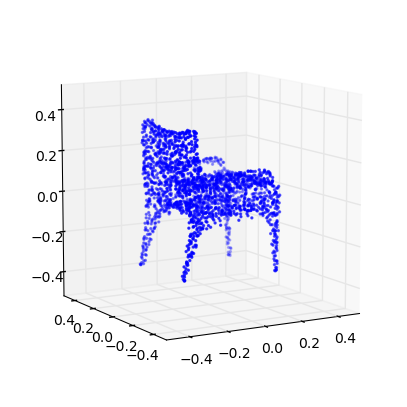

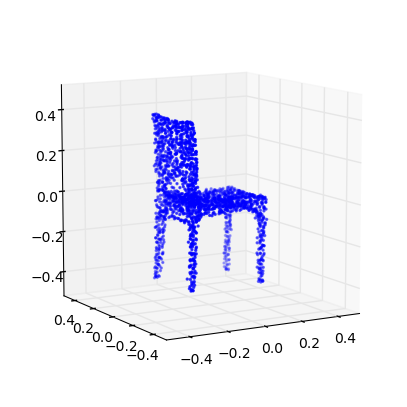

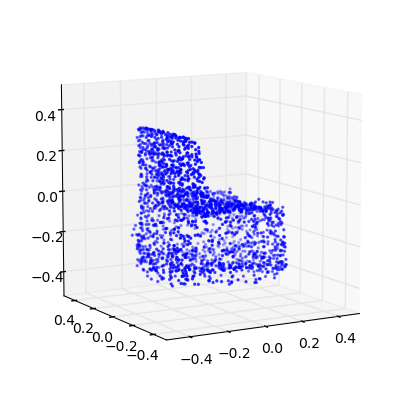

1601 (-0.46667772855447687, 0.19395526595737622)
1602 (-0.46431776699812516, 0.188229039311409)
1603 (-0.45851698854695194, 0.17273506651753964)
1604 (-0.46353489886159482, 0.18542209235222443)
1605 (-0.46598162962042766, 0.17455283617195877)
1606 (-0.46436587727588158, 0.18728679483351501)
1607 (-0.46438514823498933, 0.19971963439298712)
1608 (-0.46471471371858014, 0.17391137552002203)
1609 (-0.45942654195039168, 0.19094403412031091)
1610 (-0.45958526082660839, 0.19225946554671164)
1611 (-0.45733705033426697, 0.17980926904989325)
1612 (-0.46370051684586899, 0.17924100290174069)
1613 (-0.45785146329713905, 0.20979548342849896)
1614 (-0.46538331715956976, 0.18021484432013138)
1615 (-0.46319462864295297, 0.2111379070126492)
1616 (-0.46467557238495866, 0.17989569967207703)
1617 (-0.45665745605593144, 0.16365055837061093)
1618 (-0.45576659389164137, 0.18713472653990207)
1619 (-0.46304644423982372, 0.20021421689054239)
1620 (-0.4599282671575961, 0.18503686591334964)
1621 (-0.456078949700231

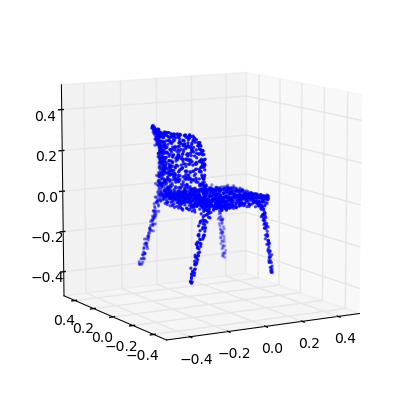

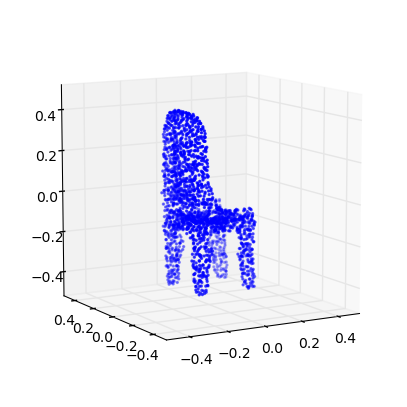

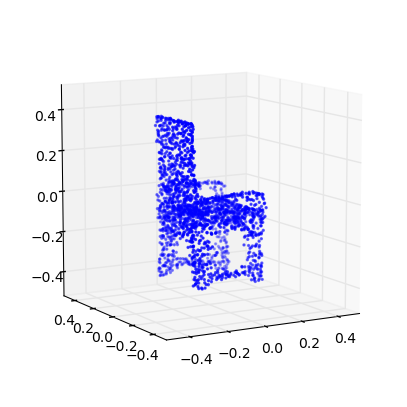

1701 (-0.45893468157104822, 0.164058451095353)
1702 (-0.45810987612475518, 0.17563514087511145)
1703 (-0.46188180394794631, 0.17894462852374368)
1704 (-0.4575346705706223, 0.18975932377835977)
1705 (-0.45821267366409302, 0.16952911602414172)
1706 (-0.45628935176393259, 0.18218291712843854)
1707 (-0.45970269519349805, 0.18002072235812311)
1708 (-0.45927174039508983, 0.17333727815876837)
1709 (-0.45442025402317876, 0.17467644227587659)
1710 (-0.45745480267897898, 0.1779672147139259)
1711 (-0.46141974200373109, 0.16275484082491501)
1712 (-0.45763988650363424, 0.17906930718732916)
1713 (-0.45887028263962787, 0.18669673606105472)
1714 (-0.45876958318378613, 0.17250075094077899)
1715 (-0.45644515079000719, 0.18749780823355136)
1716 (-0.46182970352794811, 0.18797219188317008)
1717 (-0.45867937829183497, 0.17998701755119406)
1718 (-0.46100763678550721, 0.17756261190642481)
1719 (-0.45929687645124351, 0.17746745633042377)
1720 (-0.46304476209308792, 0.17213636669127838)
1721 (-0.456277709162753

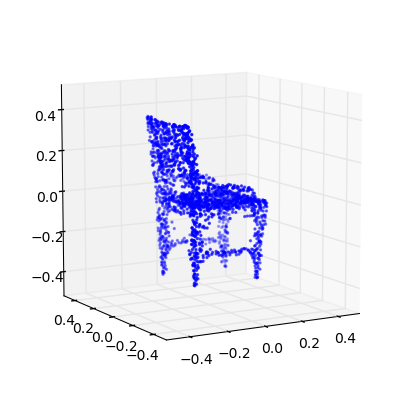

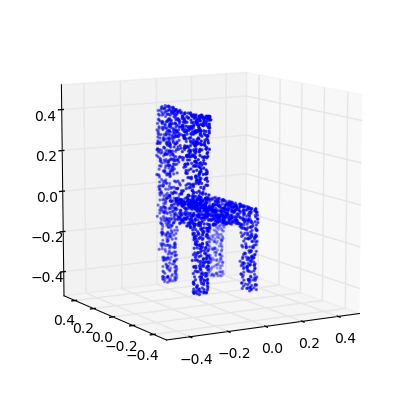

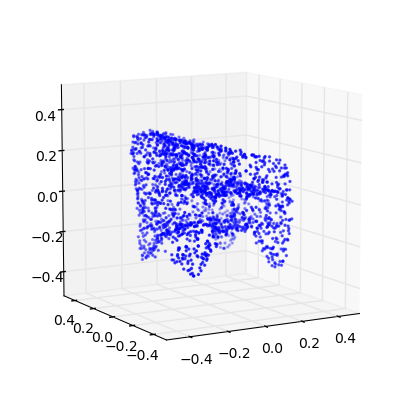

1801 (-0.45072599390278689, 0.14810769292323486)
1802 (-0.45535333908122516, 0.16906633908333984)
1803 (-0.45733756552571836, 0.17574969128422116)
1804 (-0.45966202331625899, 0.13677368669406229)
1805 (-0.45835052599077641, 0.14613897418198379)
1806 (-0.44981350121290786, 0.14367375846790231)
1807 (-0.45907968334529708, 0.14901223357604898)
1808 (-0.4576077137304389, 0.16114080729691879)
1809 (-0.45913473004880156, 0.16438553709050882)
1810 (-0.45396670025327929, 0.15307967915483142)
1811 (-0.45576539039611819, 0.15584253778924112)
1812 (-0.45553850816643754, 0.14588464181060376)
1813 (-0.4569099681532901, 0.15597382803326068)
1814 (-0.46114013143207716, 0.15363980829715729)
1815 (-0.45672360684560692, 0.15214296819075293)
1816 (-0.45092200559118517, 0.15211188080518143)
1817 (-0.45768790659697162, 0.16596226458964142)
1818 (-0.46200509745141732, 0.15142864976888118)
1819 (-0.45389755134997162, 0.15993133737989093)
1820 (-0.45352716705073481, 0.14614077754642651)
1821 (-0.4490174379037

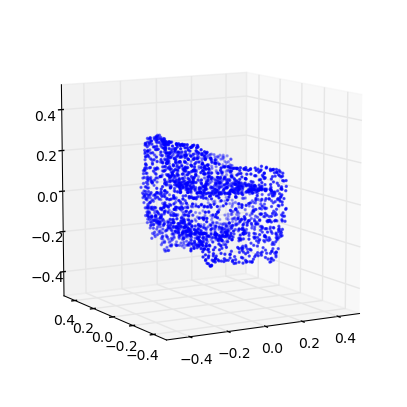

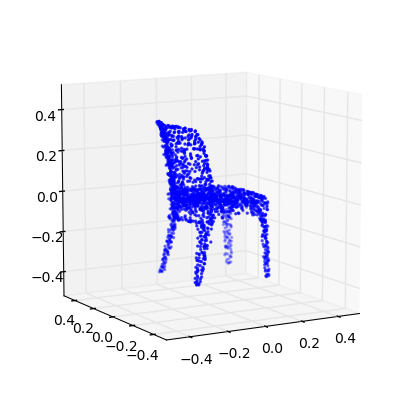

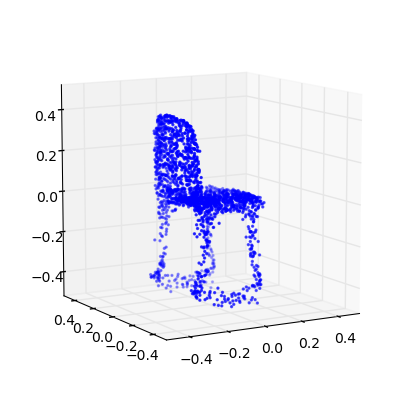

1901 (-0.44640715718269347, 0.14347719044789023)
1902 (-0.45357385873794553, 0.14730492946894272)
1903 (-0.45429988944012184, 0.15322940958582837)
1904 (-0.45395143394884857, 0.15222687241823776)
1905 (-0.45299912924351898, 0.159561135198759)
1906 (-0.45164724640224291, 0.15683661595634793)
1907 (-0.462535474093064, 0.1443002564103707)
1908 (-0.44683577288752019, 0.14244396693032721)
1909 (-0.45365515765936476, 0.13660517140575076)
1910 (-0.45433411287224812, 0.15405039489269257)
1911 (-0.459513177819874, 0.15430441174818121)
1912 (-0.45518399762070699, 0.16828609938206879)
1913 (-0.45206828687501988, 0.14863203109606452)
1914 (-0.4506010449450949, 0.1474250856301059)
1915 (-0.44826774234357086, 0.1517909305251163)
1916 (-0.45544794486916584, 0.16308789246756097)
1917 (-0.45220618403476215, 0.15188915088124896)
1918 (-0.44877366682757502, 0.15951834424682285)
1919 (-0.44387302087700886, 0.13474673972181653)
1920 (-0.45887784931970677, 0.15671208727618921)
1921 (-0.45117597683616306, 0.

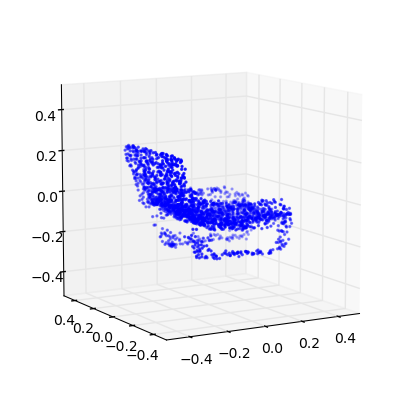

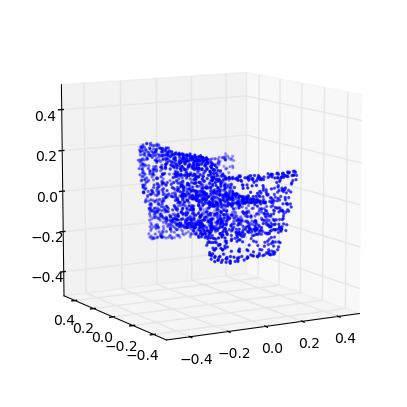

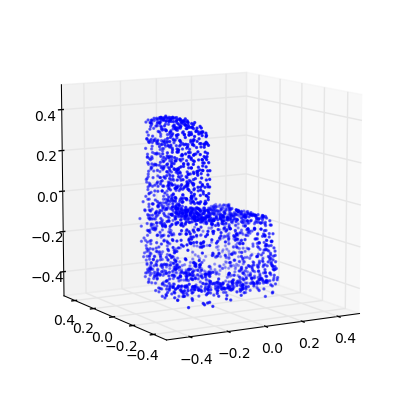

In [22]:
if do_training:
    for _ in range(max_epochs):
        loss, duration = gan._single_epoch_train(train_data, batch_size, noise_params)
        epoch = int(gan.sess.run(gan.epoch.assign_add(tf.constant(1.0))))
        print epoch, loss
        
        if save_model and (epoch % saver_step == 0 or epoch <= 5):
            checkpoint_path = osp.join(train_dir, MODEL_SAVER_ID)
            gan.saver.save(gan.sess, checkpoint_path, global_step=gan.epoch)
        
        if save_synthetic_samples and epoch in saver_step:
            syn_latent_data = gan.generate(n_syn_samples, noise_params)
            syn_data = ae.decode(syn_latent_data)
            np.savez(osp.join(synthetic_data_out_dir, 'epoch_' + str(epoch)), syn_data)
            for k in range(3):
                Point_Cloud(syn_data[k]).plot()
            
        train_stats.append((epoch,) + loss)

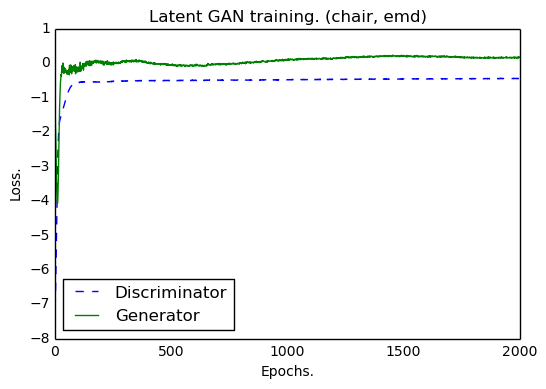

In [23]:
if plot_train_curve:
    x = range(len(train_stats))
    d_loss = [t[1] for t in train_stats]
    g_loss = [t[2] for t in train_stats]
    plt.plot(x, d_loss, '--')
    plt.plot(x, g_loss)
    plt.title('Latent GAN training. (%s, %s)' %(class_name, ae_loss))
    plt.legend(['Discriminator', 'Generator'], loc=0)
    
    plt.tick_params(axis='x', which='both', bottom='off', top='off')
    plt.tick_params(axis='y', which='both', left='off', right='off')
    
    plt.xlabel('Epochs.') 
    plt.ylabel('Loss.')